# Imports

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import requests as rs
import pandas as pd
from scipy.io import loadmat
from scipy.stats import zscore
from scipy.signal import spectrogram
from scipy.signal import periodogram
from scipy.signal import iirnotch
from scipy.signal import find_peaks
from scipy.signal import welch
from voltage_imaging import *

# Functions

# Loading file

In [3]:
meta = loadMeta()
dict_data = dict()
for fname in meta['File'].unique():
    path = os.path.join('..', 'data', fname.split('_')[0], fname + '.mes')
    dict_data[fname] = loadmat(path, squeeze_me = True)

# Plotting all recordings

## Selecting recordings to display

In [4]:
meta_plot = meta
# meta_plot = meta.query('File == "20211126_M_C_1"')

## Plotting traces

### Raw

In [5]:
show = False
pdf_name = 'traces_raw.pdf'

plt.figure(figsize = (8.3,11.7), tight_layout = 3)
cursor_figure = 1
nrow = 6
ncol = 1

with PdfPages(pdf_name) as pdf:
    
    #Looping through experiments
    for cnt,r in meta_plot.iterrows():
        cur_mat= getRecordingData(dict_data, r)
        vect = np.mean(cur_mat, axis = 0)
        vect_time = np.linspace(0, r['Duration'] - r['Start_cutoff'], num = len(vect))
        plt.subplot(nrow, ncol, cursor_figure)
        plt.plot(vect_time, vect, c = 'k', linewidth = 0.5)
        plt.xlabel('Time (ms)')
        plt.ylabel('F')
        plt.title(r['File'] + '/recording ' + str(r['Measure_ID']))

        cursor_figure += 1
        if cursor_figure > nrow*ncol:
            cursor_figure = 1
            pdf.savefig()
            if not show:
                plt.close()
            plt.figure(figsize = (8.3,11.7), tight_layout = 3)

    pdf.savefig()
    if not show:
        plt.close()

### Averaged window

#### Very high frequency (~320 khZ)

#### Michael recommendation (~1kHz)

In [6]:
show = False
pdf_name = 'traces_moving_average.pdf'

plt.figure(figsize = (8.3,11.7), tight_layout = 3)
cursor_figure = 1
nrow = 6
ncol = 2
w = 3 #Number of roi to average. At 1khZ, these are ms

with PdfPages(pdf_name) as pdf:
    
    #Looping through experiments
    for cnt,r in meta_plot.iterrows():
        cur_mat= getRecordingData(dict_data, r)
        vect = np.mean(cur_mat, axis = 0)
        vect = moving_average(vect, w)
        vect_time = np.linspace(0, r['Duration'] - r['Start_cutoff'], num = len(vect))
        plt.subplot(nrow, ncol, cursor_figure)
        plt.plot(vect_time, vect, c = 'k', linewidth = 0.5)
        plt.xlabel('Time (ms)')
        plt.ylabel('F')
        plt.title(r['File'] + '/recording ' + str(r['Measure_ID']))

        cursor_figure += 1
        if cursor_figure > nrow*ncol:
            cursor_figure = 1
            pdf.savefig()
            if not show:
                plt.close()
            plt.figure(figsize = (8.3,11.7), tight_layout = 3)

    pdf.savefig()
    if not show:
        plt.close()

### Periodograms

In [11]:
show = False
pdf_name = 'dataset_recap.pdf'

plt.figure(figsize = (8.3,11.7), tight_layout = 2)
cursor_figure = 1
nrow = 6
ncol = 3
w = 3 #Number of roi to average. At 1khZ, these are ms

with PdfPages(pdf_name) as pdf:
    
    #Looping through experiments
    for cnt,r in meta_plot.iterrows():
        
        #For the text
        plt.subplot(nrow, ncol, cursor_figure)
        str_stim = 'No stim' if pd.isna(r['Airpuff']) else 'Air puff'
        str_indicator = r['Indicator'].split('_')[1] if not pd.isna(r['Indicator']) else 'Noise'
        plt.text(0,0, r['File'] + '/Cell ' + str(r['Cell']) + '/' + str_indicator)
        plt.text(0,1, r['State'] + ' / ' + str_stim)
        plt.text(0,2, r['Mode'] + '/IM=' + str(r['Im1']) + '/PC1=' + str(r['PC1']) + '/UG=' + str(r['UG']))
        plt.ylim(3,-1)
        plt.axis('off')
        cursor_figure += 1
        
        #The averaged signal
        cur_mat= getRecordingData(dict_data, r)
        recording_duration = r['Duration'] - r['Start_cutoff']
        vect = np.mean(cur_mat, axis = 0)
        # vect = moving_average(vect, w)
        vect_time = np.linspace(0, recording_duration, num = len(vect))
        plt.subplot(nrow, ncol, cursor_figure)
        plt.plot(vect_time, vect, c = 'k', linewidth = 0.5)
        plt.xlabel('Time (ms)')
        plt.ylabel('F')
        cursor_figure += 1
        
        #The periodogram
        plt.subplot(nrow, ncol, cursor_figure)
        vect = cur_mat.flatten('F')
        nsamples = len(vect)
        vect_time = np.linspace(0, recording_duration, num = nsamples)
        freq, fft = periodogram(vect, fs = nsamples / (recording_duration*1e-3))
        plt.subplot(nrow, ncol, cursor_figure)
        plt.plot(freq, fft, c = 'k')
        plt.xscale('log')
        plt.xlabel('Frequency', c = 'k')
        plt.ylabel('FFT')  
        cursor_figure += 1
        plt.axvline(cur_mat.shape[0])
        
        if cursor_figure > nrow*ncol:
            cursor_figure = 1
            pdf.savefig()
            if not show:
                plt.close()
            plt.figure(figsize = (8.3,11.7), tight_layout = 3)

    pdf.savefig()
    if not show:
        plt.close()

# Exploring best recordings

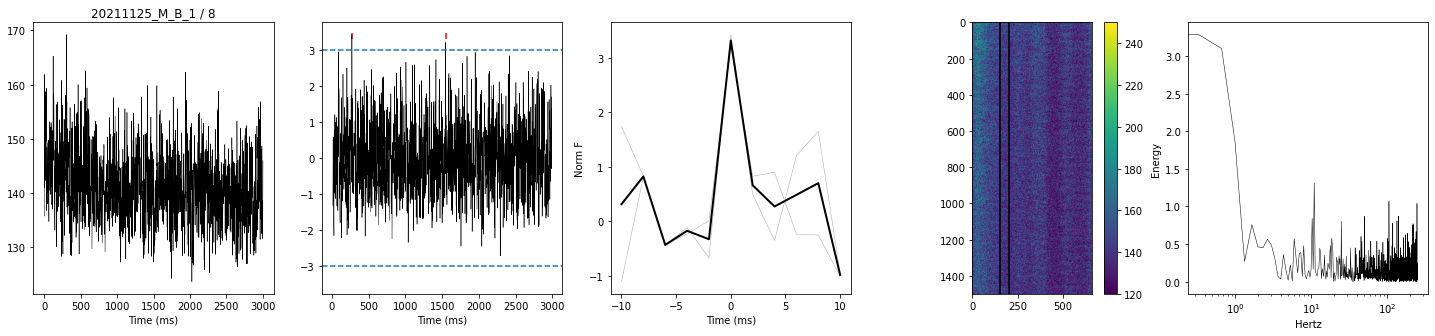

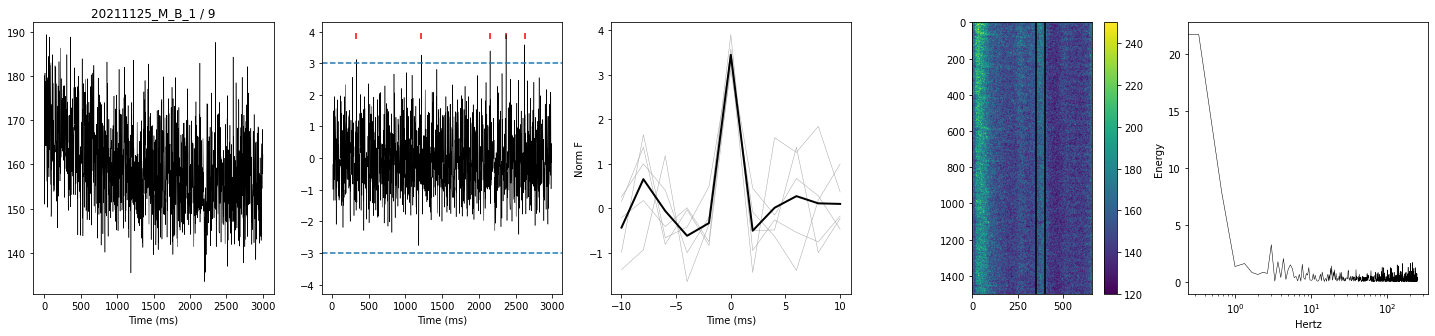

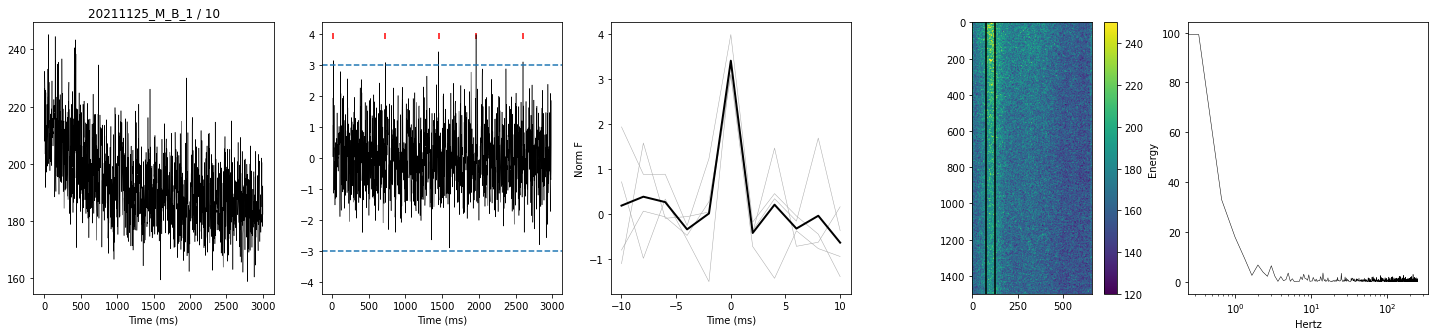

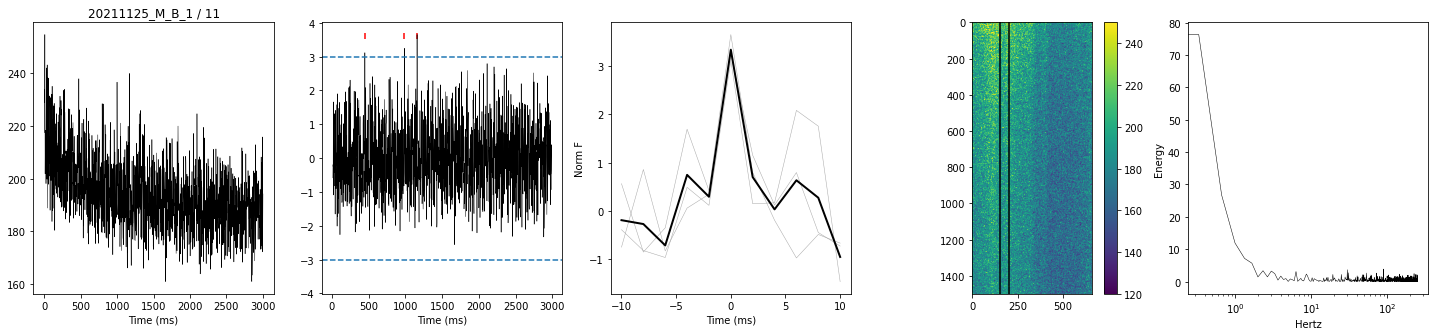

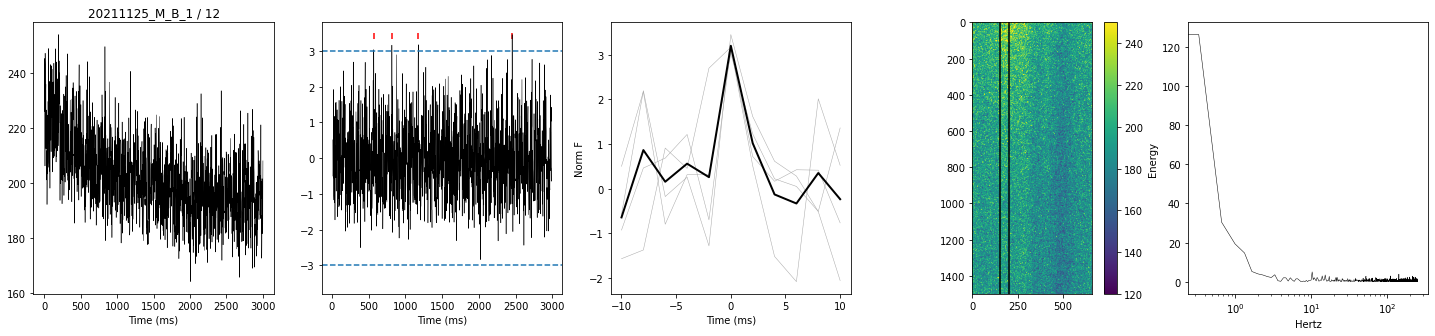

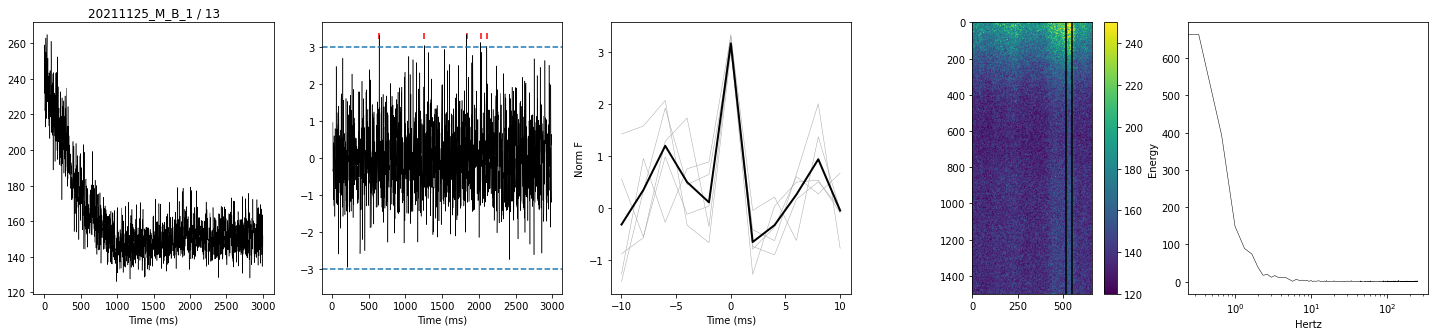

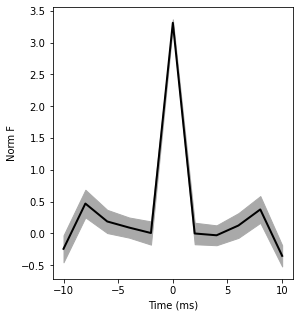

In [12]:
meta = loadMeta()
meta_plot = meta.query('(Date == "2021/11/25") & (File == "20211125_M_B_1") & (Cell == 4)')
# meta_plot = meta.query('(Date == "2021/11/26") & (File == "20211126_M_C_1") & (Cell == 9)')
# meta_plot = meta.query('(Date == "2021/11/26") & (File == "20211126_M_C_1") & (Cell == 5)')
# meta_plot = meta.query('(Date == "2021/11/26") & (File == "20211126_M_A_2") & (Cell == 4)')
# meta_plot = meta.query('(Date == "2021/11/26") & (File == "20211126_M_A_2") & (Cell == 2)')
# meta_plot = meta.query('(Date == "2021/11/25") & (File == "20211125_M_C_1") & (Cell == 4)')
# start_sample = 350
# end_sample = 550

#-------------------------------------------------------------------------------------------
# meta_plot = meta.query('(Date == "2021/11/25") & (File == "20211125_M_C_1") & (Cell == 1)')
# start_sample = 425
# end_sample = 525

#-------------------------------------------------------------------------------------------

threshold = 3
half_window = 25 #Samples
half_window_STA = 5

start_sample_global = 150
end_sample_global = 200

list_spike_shape = list()
list_fs = list()

for i,row in meta_plot.iterrows():
    
    recording_duration = row['Duration'] - row['Start_cutoff']
    cur_mat = getRecordingData(dict_data, row)

    if (start_sample_global is None):
        start_sample = 0
    else:
        start_sample = start_sample_global
    if end_sample_global is None:
        end_sample = cur_mat.shape[0]
    else:
        end_sample = end_sample_global
        
    if not pd.isna(row['Kymo_start']):
        start_sample = int(row['Kymo_start'])
    if not pd.isna(row['Kymo_end']):
        end_sample = int(row['Kymo_end'])
        
    fs = cur_mat.shape[1]/recording_duration #kHz    
    list_fs.append(fs)
    signal = np.mean(cur_mat[start_sample:end_sample,:], axis = 0)
    time_axis = np.linspace(0, recording_duration, num = len(signal))
    
    #Raw signal
    plt.figure(figsize = (25,5))
    plt.subplot(1,5,1)
    plt.plot(time_axis, signal, c = 'k', linewidth = 0.5)
    plt.xlabel('Time (ms)')
    plt.title(row['File'] + ' / ' + str(row['Measure_ID']))
    
    #Z-scored signal
    plt.subplot(1,5,2)
    zscore_val = movingZscore(signal, half_window, False)
    extreme_val = 1.1*np.max(np.abs(zscore_val))
    time_axis = np.linspace(half_window*fs, recording_duration-half_window*fs, num = len(zscore_val))
    peaks = peakDetection(zscore_val, threshold)
    peaks_neg = peakDetection(zscore_val, threshold, invert_signal = True)
    plt.plot(time_axis, zscore_val, c = 'k', linewidth = 0.5)
    plt.scatter(time_axis[peaks], [0.9*extreme_val]*len(peaks), c = 'r', marker = '|')
    plt.scatter(time_axis[peaks_neg], [-0.9*extreme_val]*len(peaks_neg), c = 'blue', marker = '|')
    plt.xlabel('Time (ms)')
    plt.ylim(-extreme_val, extreme_val)
    plt.axhline(threshold, linestyle = '--')
    plt.axhline(-threshold, linestyle = '--')
    
    #Spike shape
    plt.subplot(1,5,3)
    if len(peaks) > 0:
        mat_STA = np.zeros(shape = (len(peaks), 2*half_window_STA + 1))
        keep_row = np.ones(len(peaks), dtype = 'bool')
        for i,p in enumerate(peaks):
            vect = zscore_val[p-half_window_STA:p+half_window_STA+1]
            if len(vect) == 2*half_window_STA + 1:
                mat_STA[i,0:len(vect)] = vect
            else:
                keep_row[i] = False
        mat_STA = mat_STA[keep_row,:]
        ts = np.linspace(-half_window_STA/fs, half_window_STA/fs, num = mat_STA.shape[1])
        plt.plot(ts,mat_STA.T, c = 'darkgray', linewidth = 0.5)
        plt.plot(ts,np.mean(mat_STA, axis = 0), c = 'black', linewidth = 2)
        plt.xlabel('Time (ms)')
        plt.ylabel('Norm F')
    list_spike_shape.append(mat_STA)
    
    #Kymograph
    plt.subplot(1,5,4)
    ax = plt.imshow(cur_mat.T, vmin = 120, vmax = 250)
    plt.colorbar(ax)
    plt.axvline(start_sample, c = 'k')
    plt.axvline(end_sample, c = 'k')
    
    #Periodogram
    plt.subplot(1,5,5)
    freq, fft = periodogram(signal, fs = fs*1e3)
    # freq, fft = welch(signals, fs = fs*1e3)
    plt.plot(freq, fft, c = 'black', linewidth = 0.5)
    plt.xscale('log')
    plt.xlabel('Hertz')
    plt.ylabel('Energy')    
    
    
plt.figure(figsize = (25,5))

#We can only average if everything has the same sampling rate
if len(np.unique(list_fs)) == 1:
    plt.subplot(151)
    nrow = 0
    for mat in list_spike_shape:
        nrow += mat.shape[0]
    mat_all_spikes = np.zeros(shape = (nrow, mat.shape[1]))
    cursor = 0
    for mat in list_spike_shape:
        mat_all_spikes[cursor:(cursor+mat.shape[0]),:] = mat
        cursor += mat.shape[0]
    mval = np.mean(mat_all_spikes, axis = 0)
    std = np.std(mat_all_spikes, axis = 0)
    sem = std / np.sqrt(mat_all_spikes.shape[0])
    ts = np.linspace(-half_window_STA/fs, half_window_STA/fs, num = len(mval))
    plt.plot(ts, mval, c = 'k', linewidth = 2)
    plt.fill_between(ts, mval + sem, mval - sem, color = 'darkgray')
    plt.xlabel('Time (ms)')
    plt.ylabel('Norm F')
